In [8]:
import logging
import time
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, WebDriverException
import pandas as pd
import re

OUTPUT_CSV_PATH = 'Google_flights_030325.csv'
CURRENCY = "USD"
SNAPSHOTS = 1
TTT_RANGE = range(1, 31)
LOS_RANGE = range(1, 6)
ROUTES = [
    ("Paris", "London"),
    ("Paris", "Rome"),
    ("London", "Paris"),
    ("London", "Rome"),
    ("Rome", "London"),
    ("Rome", "Paris")
]
MAX_SEARCHES = 10000
MAX_WORKERS = 15

def configure_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler("Google_flights_030325.log"),
            logging.StreamHandler()
        ]
    )

def init_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    try:
        return webdriver.Chrome(options=options)
    except WebDriverException as e:
        logging.error(f"WebDriver error: {e}")
        return None

def generate_dates(ttt, los, snapshot_date):
    departure_date = snapshot_date + timedelta(days=ttt)
    return_date = departure_date + timedelta(days=los)
    return departure_date.strftime('%Y-%m-%d'), return_date.strftime('%Y-%m-%d')

def scrape_flight_data(origin, destination, ttt, los, snapshot_date):
    driver = init_driver()
    if not driver:
        return []

    flight_data = []
    try:
        departure_date, return_date = generate_dates(ttt, los, snapshot_date)
        search_url = f"https://www.google.com/travel/flights?q=Flights%20from%20{origin}%20to%20{destination}" \
                     f"%20on%20{departure_date}%20returning%20on%20{return_date}&curr={CURRENCY}&hl=en-US"
        driver.get(search_url)
        time.sleep(5)

        try:
            view_more_button = driver.find_element(By.XPATH, "//button[@aria-label='View more flights']")
            driver.execute_script("arguments[0].click();", view_more_button)
            time.sleep(3)
        except NoSuchElementException:
            logging.warning(f"No 'View more flights' button found for {origin} → {destination}")

        for _ in range(5):
            driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
            time.sleep(1)

        flights = driver.find_elements(By.CSS_SELECTOR, "li.pIav2d")

        for flight in flights[:100]:
            try:
                flight_text = extract_flight_text(flight)
                parsed_flight = parse_flight_details(flight_text, snapshot_date, origin, destination, ttt, los, departure_date, return_date)
                if parsed_flight:
                    flight_data.append(parsed_flight)
            except Exception as e:
                logging.error(f"Error parsing flight data: {e}")

    except Exception as e:
        logging.error(f"Error during scraping for {origin} → {destination}: {e}")

    finally:
        driver.quit()

    return flight_data

def extract_flight_text(li_element):
    flight_div = li_element.find_element(By.CLASS_NAME, "JMc5Xc")
    return flight_div.get_attribute("aria-label")

def parse_flight_details(flight_text, snapshot_date, origin, destination, ttt, los, departure_date, return_date):
    try:
        price = re.search(r'From (\d+) US dollars', flight_text)
        stops = re.search(r'(\d+ stop|Nonstop)', flight_text)
        airline = re.search(r'with ([\w\s]+)\.', flight_text)
        departure_airport = re.search(r'Leaves (.+?) at', flight_text)
        departure_time = re.search(r'at (\d{1,2}:\d{2} [AP]M)', flight_text)
        arrival_airport = re.search(r'arrives at (.+?) at', flight_text)
        arrival_time = re.search(r'at (\d{1,2}:\d{2} [AP]M) on', flight_text)
        duration = re.search(r'Total duration (\d+ hr \d+ min)', flight_text)
        layover = re.search(r'Layover \(1 of 1\) is a (\d+ hr \d+ min)', flight_text)

        return {
            "Website": "Google flights",
            "Snapshot date": snapshot_date.strftime("%Y-%m-%d"),
            "Airline": airline.group(1) if airline else "N/A",
            "Price": price.group(1) if price else "N/A",
            "TTT": ttt,
            "LOS": los,
            "Origin": origin,
            "Destination": destination,
            "Departure date": departure_date,
            "Departure Airport": departure_airport.group(1) if departure_airport else "N/A",
            "Departure Time": departure_time.group(1) if departure_time else "N/A",
            "Layover": layover.group(1) if layover else "None",
            "Stops": stops.group(1) if stops else "N/A",
            "Return date": return_date,
            "Arrival Airport": arrival_airport.group(1) if arrival_airport else "N/A",
            "Arrival Time": arrival_time.group(1) if arrival_time else "N/A",
            "Duration": duration.group(1) if duration else "N/A",
        }
    
    except Exception as e:
        logging.error(f"Error parsing flight details: {e}")
        return None

def run_scraping(snapshot_dates):
    data = []
    search_count = 0

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = []
        for snapshot_date in snapshot_dates:
            for origin, destination in ROUTES:
                for ttt in TTT_RANGE:
                    for los in LOS_RANGE:
                        if search_count >= MAX_SEARCHES:
                            break
                        futures.append(executor.submit(scrape_flight_data, origin, destination, ttt, los, snapshot_date))
                        search_count += 1
                        logging.info(f"Scheduled search {search_count} of {MAX_SEARCHES}")

        for future in as_completed(futures):
            try:
                flight_data = future.result()
                if flight_data:
                    data.extend(flight_data)
            except Exception as e:
                logging.error(f"Error in future execution: {e}")

    return data

def save_to_csv(data):
    df = pd.DataFrame(data)
    df.to_csv(OUTPUT_CSV_PATH, index=False)
    logging.info(f"Data saved to {OUTPUT_CSV_PATH}")

def main():
    configure_logging()
    snapshot_dates = [datetime.now() + timedelta(days=7 * i) for i in range(SNAPSHOTS)]
    flight_data = run_scraping(snapshot_dates)
    save_to_csv(flight_data)

if __name__ == "__main__":
    main()

2025-03-03 11:13:14,705 - INFO - Scheduled search 1 of 10000
2025-03-03 11:13:14,709 - INFO - Scheduled search 2 of 10000
2025-03-03 11:13:14,713 - INFO - Scheduled search 3 of 10000
2025-03-03 11:13:14,714 - INFO - Scheduled search 4 of 10000
2025-03-03 11:13:14,715 - INFO - Scheduled search 5 of 10000
2025-03-03 11:13:14,720 - INFO - Scheduled search 6 of 10000
2025-03-03 11:13:14,728 - INFO - Scheduled search 7 of 10000
2025-03-03 11:13:14,732 - INFO - Scheduled search 8 of 10000
2025-03-03 11:13:14,741 - INFO - Scheduled search 9 of 10000
2025-03-03 11:13:14,749 - INFO - Scheduled search 10 of 10000
2025-03-03 11:13:14,755 - INFO - Scheduled search 11 of 10000
2025-03-03 11:13:14,760 - INFO - Scheduled search 12 of 10000
2025-03-03 11:13:14,764 - INFO - Scheduled search 13 of 10000
2025-03-03 11:13:14,769 - INFO - Scheduled search 14 of 10000
2025-03-03 11:13:14,772 - INFO - Scheduled search 15 of 10000
2025-03-03 11:13:14,775 - INFO - Scheduled search 16 of 10000
2025-03-03 11:13:

In [218]:
df = pd.read_csv("/Users/nadavcohen/Desktop/ColmanDesktop/Colman/project/flights project/csv/GoogleFlight030325.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88115 entries, 0 to 88114
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Website            88115 non-null  object 
 1   Snapshot date      88115 non-null  object 
 2   Airline            88115 non-null  object 
 3   Price              88115 non-null  int64  
 4   TTT                88115 non-null  int64  
 5   LOS                88115 non-null  int64  
 6   Origin             88115 non-null  object 
 7   Destination        88115 non-null  object 
 8   Departure date     88115 non-null  object 
 9   Departure Airport  88115 non-null  object 
 10  Departure Time     88115 non-null  object 
 11  Layover            88115 non-null  float64
 12  Stops              88115 non-null  int64  
 13  Return date        88115 non-null  object 
 14  Arrival Airport    88115 non-null  object 
 15  Arrival Time       88115 non-null  object 
 16  Duration           881

,Website,Snapshot date,Airline,Price,TTT,LOS,Origin,Destination,Departure date,Departure Airport,Departure Time,Layover,Stops,Return date,Arrival Airport,Arrival Time,Duration
0,Google flights,2025-03-03,easyJet,99,1,1,Paris,London,2025-03-04,CDG,10:15 AM,0.0,0,2025-03-05,LTN,10:15 AM,1.33
1,Google flights,2025-03-03,easyJet,99,1,1,Paris,London,2025-03-04,CDG,1:55 PM,0.0,0,2025-03-05,LTN,1:55 PM,1.25
2,Google flights,2025-03-03,easyJet,99,1,1,Paris,London,2025-03-04,CDG,4:00 PM,0.0,0,2025-03-05,LTN,4:00 PM,1.25
3,Google flights,2025-03-03,Vueling,112,1,1,Paris,London,2025-03-04,ORY,2:10 PM,0.0,0,2025-03-05,LHR,2:10 PM,1.25
4,Google flights,2025-03-03,easyJet,105,1,1,Paris,London,2025-03-04,CDG,9:45 PM,0.0,0,2025-03-05,LTN,9:45 PM,1.25


In [219]:
count_zeros = (df['Airline'] == "0").sum()
df_unclean = df[df['Airline'] != "0"]
df_unclean['Airline'] = df_unclean['Airline'].str.split(' and ').str[0]
df_unclean.to_csv("cleaned_flight_data.csv", index=False)
print("Cleaned CSV file has been saved as 'cleaned_flight_data.csv'.")

/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_97696/286242770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unclean['Airline'] = df_unclean['Airline'].str.split(' and ').str[0]


Cleaned CSV file has been saved as 'cleaned_flight_data.csv'.


In [220]:
clean_airline_df= pd.read_csv("/Users/nadavcohen/Desktop/ColmanDesktop/Colman/project/flights project/cleaned_flight_data.csv")
clean_airline_df.head()

,Website,Snapshot date,Airline,Price,TTT,LOS,Origin,Destination,Departure date,Departure Airport,Departure Time,Layover,Stops,Return date,Arrival Airport,Arrival Time,Duration
0,Google flights,2025-03-03,easyJet,99,1,1,Paris,London,2025-03-04,CDG,10:15 AM,0.0,0,2025-03-05,LTN,10:15 AM,1.33
1,Google flights,2025-03-03,easyJet,99,1,1,Paris,London,2025-03-04,CDG,1:55 PM,0.0,0,2025-03-05,LTN,1:55 PM,1.25
2,Google flights,2025-03-03,easyJet,99,1,1,Paris,London,2025-03-04,CDG,4:00 PM,0.0,0,2025-03-05,LTN,4:00 PM,1.25
3,Google flights,2025-03-03,Vueling,112,1,1,Paris,London,2025-03-04,ORY,2:10 PM,0.0,0,2025-03-05,LHR,2:10 PM,1.25
4,Google flights,2025-03-03,easyJet,105,1,1,Paris,London,2025-03-04,CDG,9:45 PM,0.0,0,2025-03-05,LTN,9:45 PM,1.25


In [221]:
def remove_outliers(df):
    grouped = df.groupby(['Origin', 'Destination'])
    rows_to_keep = []
    
    for (origin, destination), group in grouped:
        Q1 = group['Price'].quantile(0.25)
        Q3 = group['Price'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_group = group[(group['Price'] >= lower_bound) & (group['Price'] <= upper_bound)]
        rows_to_keep.append(filtered_group)
    cleaned_df = pd.concat(rows_to_keep)
    
    return cleaned_df

cleaned_df = remove_outliers(clean_airline_df)
cleaned_df.head()

,Website,Snapshot date,Airline,Price,TTT,LOS,Origin,Destination,Departure date,Departure Airport,Departure Time,Layover,Stops,Return date,Arrival Airport,Arrival Time,Duration
29779,Google flights,2025-03-03,easyJet,100,1,1,London,Paris,2025-03-04,LTN,6:45 PM,0.0,0,2025-03-05,CDG,6:45 PM,1.33
29780,Google flights,2025-03-03,Vueling,103,1,1,London,Paris,2025-03-04,LHR,3:15 PM,0.0,0,2025-03-05,ORY,3:15 PM,1.50
29781,Google flights,2025-03-03,easyJet,106,1,1,London,Paris,2025-03-04,LTN,10:50 AM,0.0,0,2025-03-05,CDG,10:50 AM,1.33
29782,Google flights,2025-03-03,easyJet,106,1,1,London,Paris,2025-03-04,LTN,12:55 PM,0.0,0,2025-03-05,CDG,12:55 PM,1.33
29783,Google flights,2025-03-03,easyJet,115,1,1,London,Paris,2025-03-04,LTN,7:10 AM,0.0,0,2025-03-05,CDG,7:10 AM,1.33


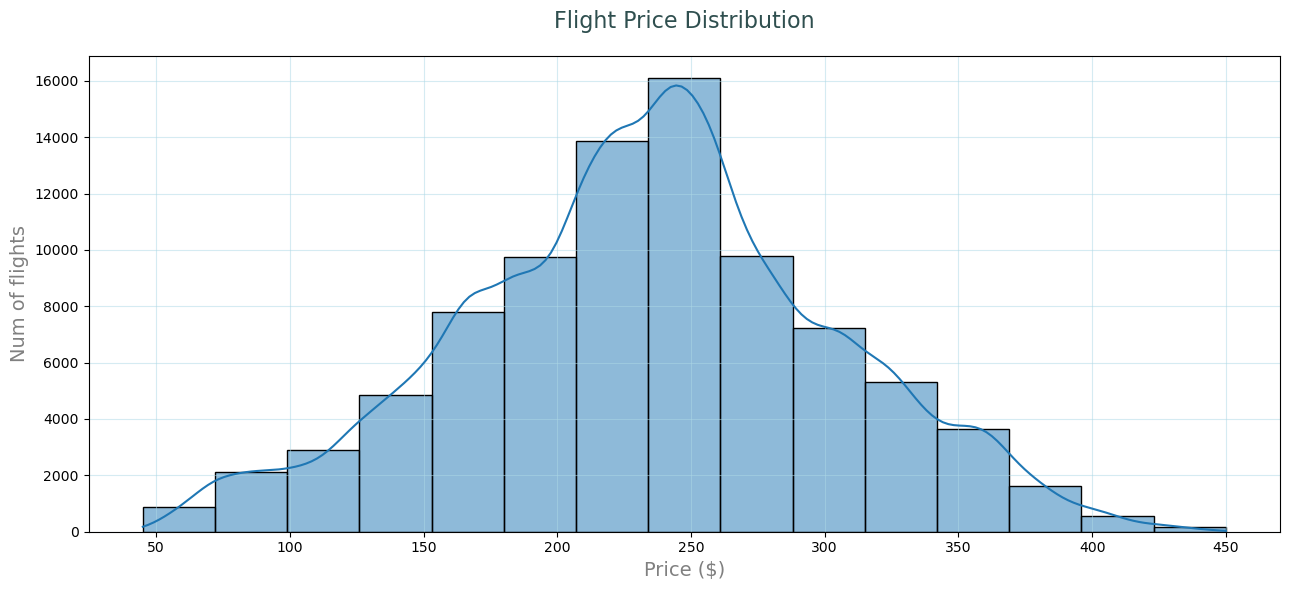

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(13, 6))
sns.histplot(cleaned_df['Price'], bins=15, kde=True)
plt.title('Flight Price Distribution', fontsize=16, color='darkslategray', pad=20)
plt.xlabel('Price ($)', fontsize=14, color='gray')
plt.ylabel('Num of flights', fontsize=14, color='gray')
plt.grid(True, linestyle='-', color='lightblue', alpha=0.5)
plt.tight_layout()
plt.show()


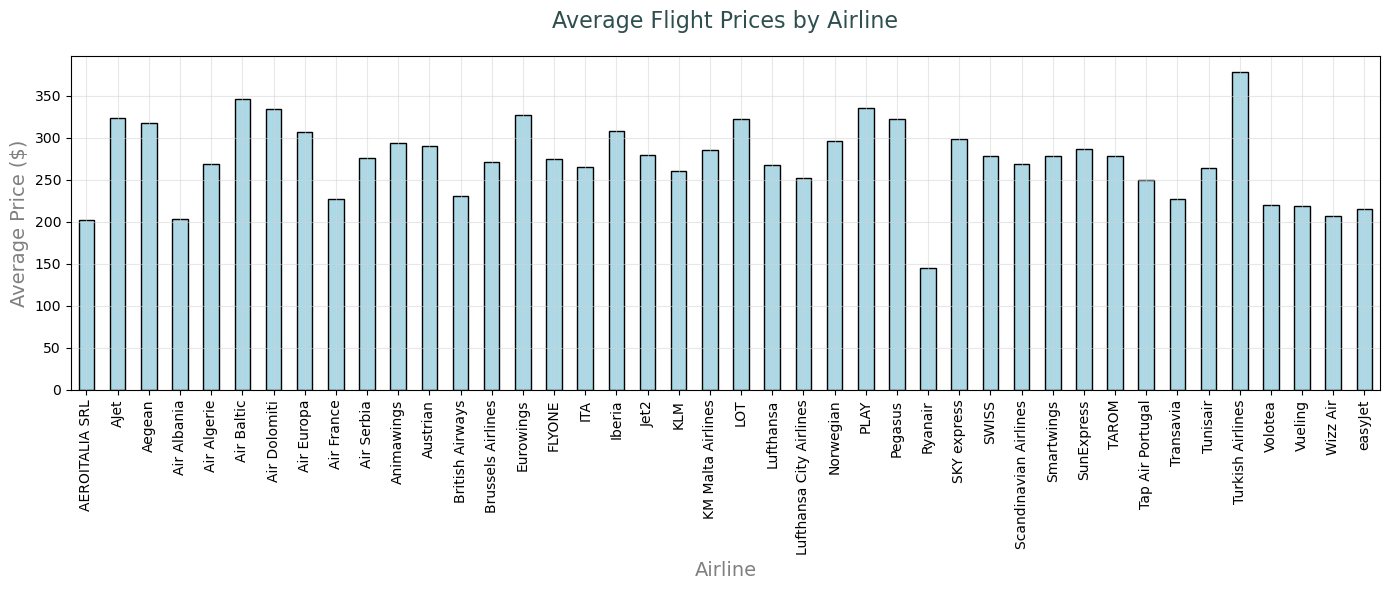

In [225]:
avg_prices = cleaned_df.groupby('Airline')['Price'].mean()
plt.figure(figsize=(14, 6))
avg_prices.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Average Flight Prices by Airline', fontsize=16, color='darkslategray', pad=20)
plt.xlabel('Airline', fontsize=14, color='gray')
plt.ylabel('Average Price ($)', fontsize=14, color='gray')
plt.grid(True, linestyle='-', color='lightgray', alpha=0.5)
plt.tight_layout()
plt.show()

In [226]:
# count_zeros = (df['Airline'] == "0").sum()
# df = df[df['Airline'] != "0"]

# # Save the cleaned data to a new CSV file
# df.to_csv("cleaned_flight_data.csv", index=False)

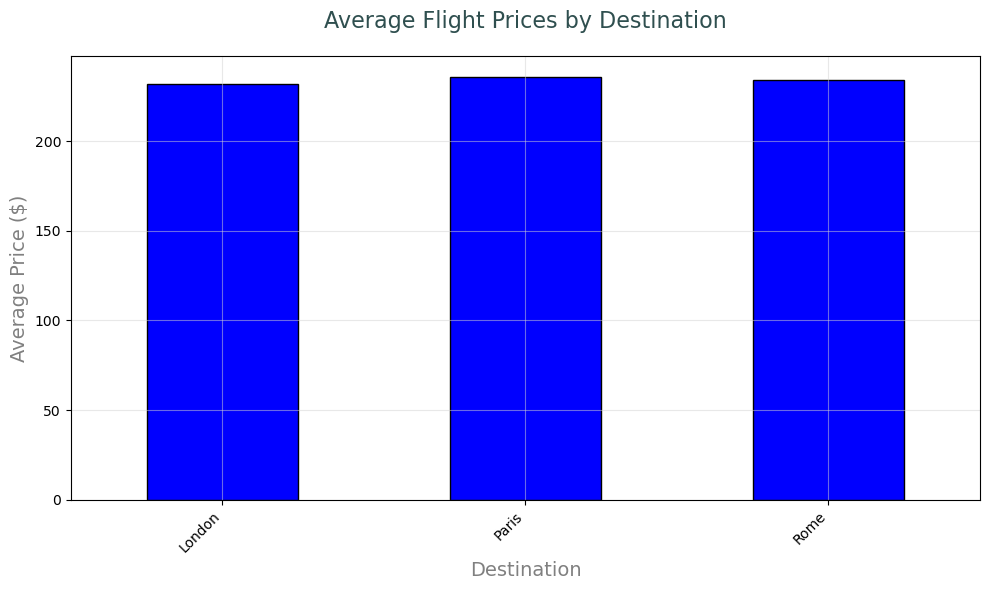

In [227]:

avg_prices_by_destination = cleaned_df.groupby('Destination')['Price'].mean()
plt.figure(figsize=(10, 6))
avg_prices_by_destination.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Average Flight Prices by Destination', fontsize=16, color='darkslategray', pad=20)
plt.xlabel('Destination', fontsize=14, color='gray')
plt.ylabel('Average Price ($)', fontsize=14, color='gray')
plt.grid(True, linestyle='-', color='lightgray', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_97696/4179202261.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

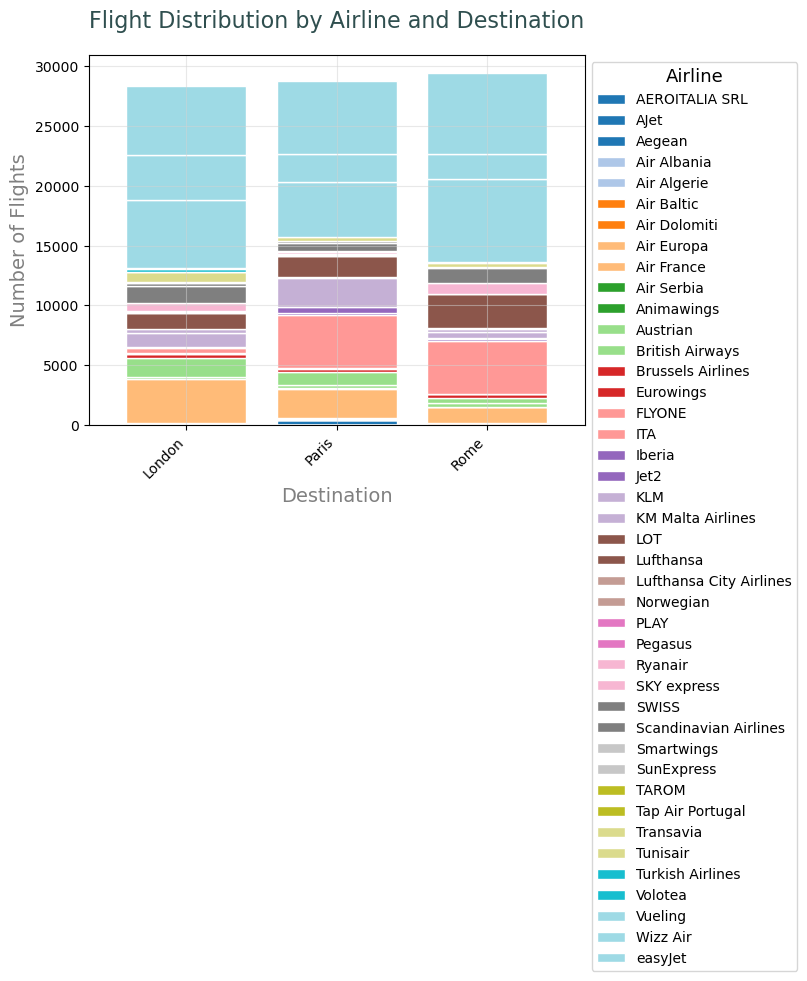

In [228]:
flight_counts = cleaned_df.groupby(['Destination', 'Airline']).size().unstack()
plt.figure(figsize=(10, 6))
flight_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='white', width=0.8)
plt.title('Flight Distribution by Airline and Destination', fontsize=16, color='darkslategray', pad=20)
plt.xlabel('Destination', fontsize=14, color='gray')
plt.ylabel('Number of Flights', fontsize=14, color='gray')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='-', color='lightgray', alpha=0.5)
plt.legend(title='Airline', title_fontsize='13', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_97696/379718347.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cleaned_df, x='Destination', y='Layover', palette='coolwarm')
/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_97696/379718347.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Destination', y='Duration', palette='viridis')


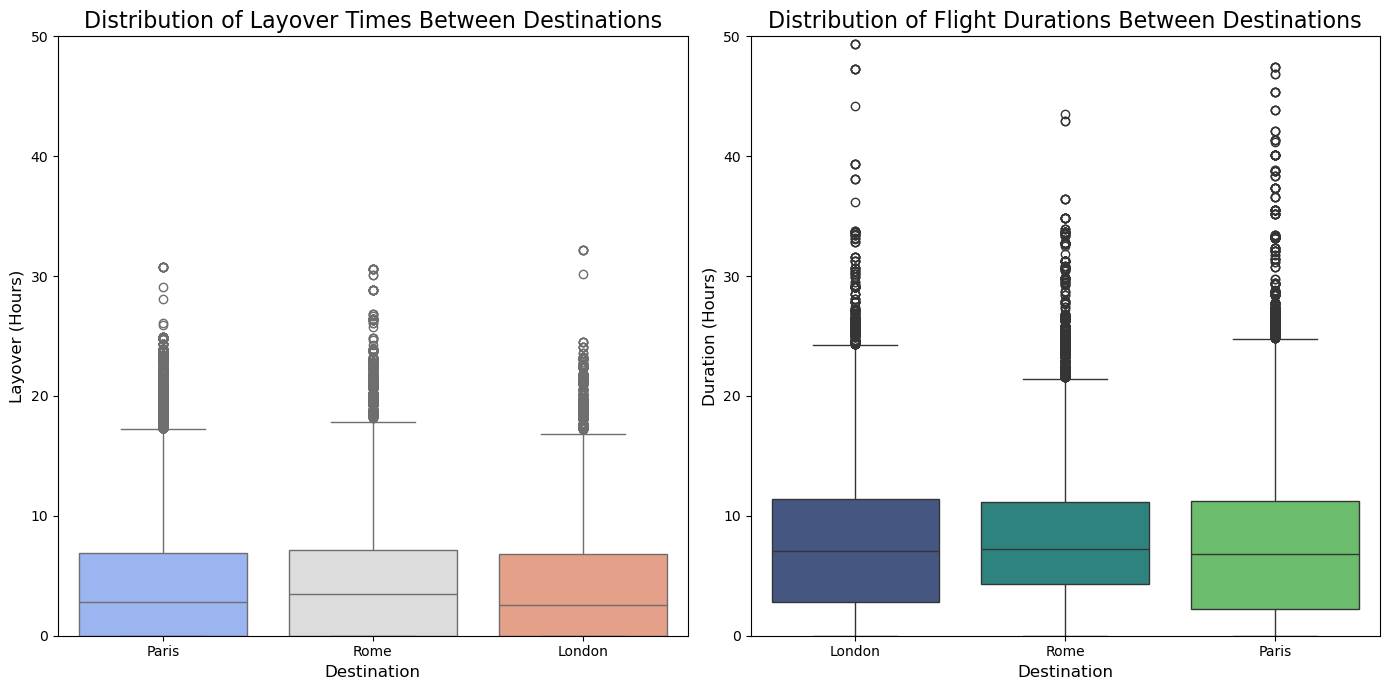

In [229]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.boxplot(data=cleaned_df, x='Destination', y='Layover', palette='coolwarm')
plt.title('Distribution of Layover Times Between Destinations', fontsize=16)
plt.xlabel('Destination', fontsize=12)
plt.ylabel('Layover (Hours)', fontsize=12)
plt.ylim(0, 50)  
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Destination', y='Duration', palette='viridis')
plt.title('Distribution of Flight Durations Between Destinations', fontsize=16)
plt.xlabel('Destination', fontsize=12)
plt.ylabel('Duration (Hours)', fontsize=12)
plt.ylim(0, 50)
plt.tight_layout()
plt.show()

/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_97696/3013770038.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cleaned_df, x='Departure Airport', y='Price', palette='coolwarm')


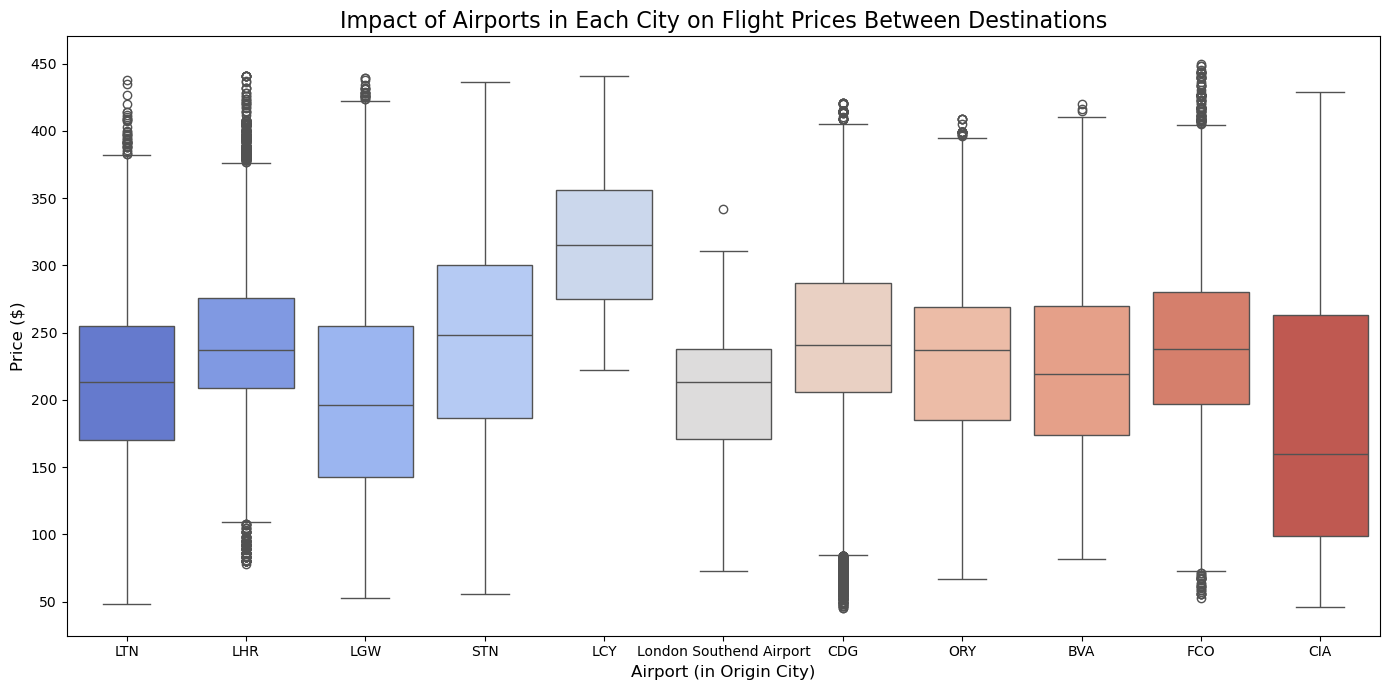

In [230]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=cleaned_df, x='Departure Airport', y='Price', palette='coolwarm')
plt.title('Impact of Airports in Each City on Flight Prices Between Destinations', fontsize=16)
plt.xlabel('Airport (in Origin City)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.tight_layout()
plt.show()

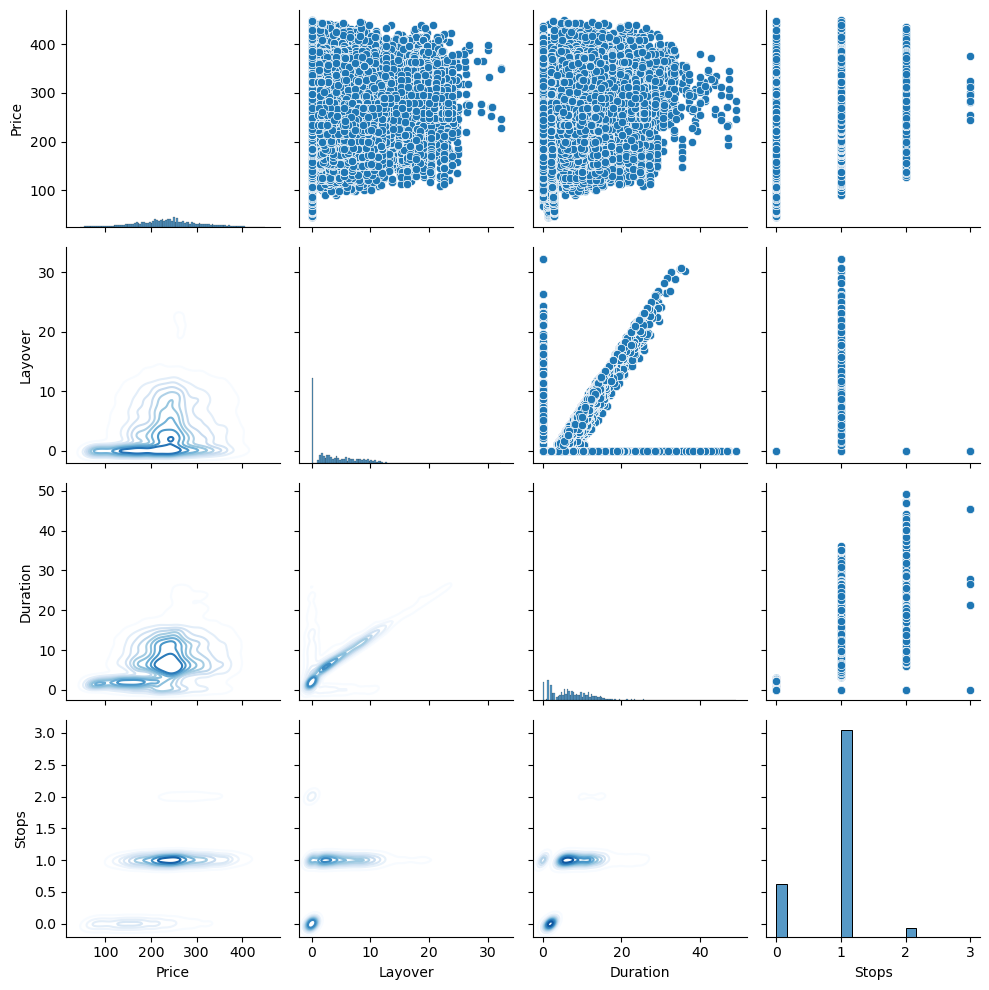

In [233]:
cleaned_df['Price'] = pd.to_numeric(cleaned_df['Price'], errors='coerce')
cleaned_df['Layover'] = pd.to_numeric(cleaned_df['Layover'], errors='coerce')
cleaned_df['Duration'] = pd.to_numeric(cleaned_df['Duration'], errors='coerce')
cleaned_df['Stops'] = pd.to_numeric(cleaned_df['Stops'], errors='coerce')

numeric_vars = ['Price', 'Layover', 'Duration', 'Stops']

# Create PairGrid for numeric variables only
g = sns.PairGrid(cleaned_df, vars=numeric_vars, height=2.5)

# Display relationships with scatter plots for the upper triangle
g.map_upper(sns.scatterplot)

# Display density estimation with KDE for the lower triangle (only numeric variables)
g.map_lower(sns.kdeplot, cmap="Blues")

# Display histograms on the diagonal
g.map_diag(sns.histplot, kde_kws={'color': 'black'})

# Display the grid
plt.tight_layout()
plt.show()